<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Rainforest%20Connection%20Species%20Audio%20Detection/banner.png" width="1000"></center>
<br>
<center><h1>Rainforest - Audio classification Tensorflow starter</h1></center>
<br>

#### References:
- [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [RFCX: train resnet50 with TPU](https://www.kaggle.com/yosshi999/rfcx-train-resnet50-with-tpu)
- [Getting Started: Rainforest EDA with TFRecords](https://www.kaggle.com/jessemostipak/getting-started-rainforest-eda-with-tfrecords)

## Dependencies

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, re, warnings, random, glob
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display as Idisplay
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn
import tensorflow_addons as tfa

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 1e-3 * REPLICAS
EPOCHS = 25
HEIGHT = 467
WIDTH = 512
CHANNELS = 3
N_CLASSES = 24
ES_PATIENCE = 5
N_FOLDS = 5
FOLDS_USED = 5
TTA_STEPS = 15 # Do TTA if > 0
MIN_CROP_SIZE = 10
CROP_SIZE = 6

# Load data

We have two different `.csv` files, `train_tp.csv` has the information of all true positive species labels and `train_fp.csv` has the information of all false positive species labels.

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = '/kaggle/input/rfcx-species-audio-detection/'
train_fp = pd.read_csv(f'{database_base_path}train_fp.csv')
train_tp = pd.read_csv(f'{database_base_path}train_tp.csv')

print(f'Train false positive samples: {len(train_fp)}')
display(train_fp.head())
print(f'Train true positive samples: {len(train_tp)}')
display(train_tp.head())

GCS_PATH = KaggleDatasets().get_gcs_path('rfcx-species-audio-detection')

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test/*.tfrec')

NUM_TRAINING_SAMPLES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_SAMPLES = count_data_items(TEST_FILENAMES)

print(f'GCS: train samples: {NUM_TRAINING_SAMPLES}')
print(f'GCS: test samples: {NUM_TEST_SAMPLES}')

Train false positive samples: 7781


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984


Train true positive samples: 1216


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


GCS: train samples: 4727
GCS: test samples: 1992


## Augmentation

In [6]:
def data_augment(sample):
    image = sample['audio_wav']
    
    gau = L.GaussianNoise(0.3)
    image = tf.cond(tf.random.uniform([]) < 0.5, lambda: gau(image, training=True), lambda: image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_flip_left_right(image)
            
    sample['audio_wav'] = image
    return sample

## Auxiliary functions

## Audio cropping diagram

#### Workflow
1. Apply `crop_audio()` to the audio.
 - If the audio has less than the `min_crop_size` pad will be added.
2. Apply `random_crop_audio()` to the audio.
 - The resulting audio will have length equal to `crop_size`.

### 1st example

If possible, equal padding is applied to both side of the crop.

![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Rainforest%20Connection%20Species%20Audio%20Detection/Audio%20crop%20diagram_2.png)

### 2nd example

If equal padding is not possible, more padding will be added to one side.

![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Rainforest%20Connection%20Species%20Audio%20Detection/Audio%20crop%20diagram.png)

In [7]:
def crop_audio(audio, tmin, tmax, min_crop_size=MIN_CROP_SIZE, sample_rate=48000, max_size=60.):
    """
        Crops a 'waveform' file to have {min_crop_size} size given, {tmin}, {tmax}, {sample_rate} and {max_size}.
    """
    label_size = tmax - tmin
    
    if label_size >= min_crop_size: # No padding needed
        cut_min = tmin
        cut_max = tmax        
    else: # Needs padding
        pad_start = (min_crop_size - label_size) / 2
        cut_min = tf.maximum(0., (tmin - pad_start))
        
        pad_end = (min_crop_size - (label_size - cut_min))
        cut_max = tf.minimum(max_size, (tmax + pad_end))
        
        cut_size = cut_max - cut_min
        
        if cut_size < min_crop_size:
            cut_min = tf.maximum(0., (cut_min - (min_crop_size - cut_size)))
        
    cut_size = cut_max - cut_min
    
    # Casting tensors
    cut_min = tf.cast((cut_min * sample_rate), tf.int32)
    cut_max = tf.cast((cut_max * sample_rate), tf.int32)
    cut_size = tf.cast((cut_size * sample_rate), tf.int32)
    
    audio = audio[cut_min:cut_max] # croping the audio
    audio = audio[:cut_size] # making sure it has the max size
    
    audio = tf.reshape(audio, [cut_size]) # making sure it has the expected shape
    return audio

def random_crop_audio(audio, crop_size=CROP_SIZE, sample_rate=48000, max_size=60):
    """
        Randomly crops a 'waveform' file to have {crop_size} size given, {sample_rate} and {max_size}.
    """
    start = tf.random.uniform([], minval=0, 
                              maxval=(max_size - crop_size), 
                              dtype=tf.int32)
    cut_min = start * sample_rate
    cut_max = (start + crop_size) * sample_rate
    
    audio_size = len(audio)
    if cut_max > audio_size:
        cut_min -= cut_max - audio_size
        cut_max = cut_min + (crop_size * sample_rate)
    
    # Casting tensors
    cut_min = tf.cast(cut_min, tf.int32)
    cut_max = tf.cast(cut_max, tf.int32)
    cut_size = tf.cast((crop_size*sample_rate), tf.int32)
    
    audio = audio[cut_min:cut_max] # croping the audio
    audio = audio[:cut_size] # making sure it has the max size
    
    audio = tf.reshape(audio, [cut_size]) # making sure it has the expected shape
    return audio

In [8]:
# Datasets utility functions
def decode_audio(audio_binary):
    """
        Decode a 16-bit PCM WAV file to a float tensor.
    """
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)
    return audio

def string_split_semicolon(column):
    split_labels_sc = tf.strings.split(column, sep=';')
    return split_labels_sc

def string_split_comma(column):
    split_labels_c = tf.strings.split(column, sep=',')
    return split_labels_c

def get_label_info(label_info):
    first_split = string_split_semicolon(label_info)
    remove_quotes = tf.strings.regex_replace(first_split, '"', "")
    label_info = string_split_comma(remove_quotes)
    return label_info

def get_spectrogram(waveform, padding=False, min_padding=48000):
    """
        Transforms a 'waveform' into a 'spectrogram', adding padding if needed.
    """
    waveform = tf.cast(waveform, tf.float32)
    if padding:
        # Padding for files with less than {min_padding} samples
        zero_padding = tf.zeros([min_padding] - tf.shape(waveform), dtype=tf.float32)
        # Concatenate audio with padding so that all audio clips will be of the same length
        waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=512, fft_length=2048)
    spectrogram = tf.abs(spectrogram)
    return spectrogram
    
def get_spectrogram_tf(example):
    """
        Transforms a 'waveform' tensor into a 'spectrogram'.
        Applied to a Tensorflow dataset.
    """
    audio = example['audio_wav']
    spectrogram = get_spectrogram(audio)
    example['audio_wav'] = spectrogram
    return example

def prepare_sample(example):
    """
        1. Resize samples to the expected size.
        2. Convert gray scales (1 channel) images to RGB (3 channels) format.
    """
    sample = example['audio_wav']
    
    sample = tf.expand_dims(sample, axis=-1)
    sample = tf.image.resize(sample, [HEIGHT, WIDTH])
    sample = tf.image.grayscale_to_rgb(sample)
    sample = sample / 255. # Scalse
    
    example['audio_wav'] = sample
    return example

def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode PCM WAV file.
        3. Break down the information from 'label_info' into other features.
        4. Crop the 'audio' waveform if needed.
        5. Returns the features as a dictionary.
    """
    TFREC_FORMAT = {
        'audio_wav': tf.io.FixedLenFeature([], tf.string), 
        'recording_id': tf.io.FixedLenFeature([], tf.string), 
        'label_info': tf.io.FixedLenFeature([], tf.string, default_value='-1,-1,0,0,0,0,1'), 
    }
        
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    audio = decode_audio(example['audio_wav'])
    
    # Break down 'label_info' into the data columns
    label_info = get_label_info(example['label_info'])
    species_id = tf.strings.to_number(tf.gather_nd(label_info, [0, 0]), tf.int32)
#     songtype_id = tf.strings.to_number(tf.gather_nd(label_info, [0, 1]), tf.int32)
    tmin = tf.strings.to_number(tf.gather_nd(label_info, [0, 2]))
#     fmin = tf.strings.to_number(tf.gather_nd(label_info, [0, 3]))
    tmax = tf.strings.to_number(tf.gather_nd(label_info, [0, 4]))
#     fmax = tf.strings.to_number(tf.gather_nd(label_info, [0, 5]))
    is_tp = tf.strings.to_number(tf.gather_nd(label_info, [0, 6]), tf.int32)
    
    if labeled:
        audio = crop_audio(audio, tmin, tmax)
        
    audio = random_crop_audio(audio)            
        
    features = {'audio_wav': audio, 
                'recording_id': example['recording_id'], 
#                 'species_id': species_id, 
                'species_id': tf.one_hot(tf.cast(species_id, tf.int32), N_CLASSES), 
                'is_tp': is_tp
               }
    return features

def load_dataset(filenames, labeled=True, ordered=False):
    """
        Load and parse the TFRecords.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(filenames)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

def conf_output(sample, labeled=True):
    """
        Configure the output of the dataset.
    """
    output = ({'input_audio': sample['audio_wav']}, sample['species_id'])
    return output

def _filtterTP(example):
    return example['is_tp'] == 1

def get_dataset(filenames, labeled=True, ordered=False, repeated=False, augment=False):
    """
        1. Load TFRecord files, parse and generate features (waveform and meta-data).
        2. Filter the dataset to contain only true positive samples.
        3. Create 'spectrogram' from the 'waveform'.
        4. Prepare image for the model.
        5. Configure data to have the expected output format.
        6. Apply Tensorflow data functions to optimize training.
        
        Returns a Tensorflow dataset ready for training or inference.
    """
    dataset = load_dataset(filenames, labeled=labeled)
    
    if labeled:
        dataset = dataset.filter(_filtterTP)
    
    dataset = dataset.map(get_spectrogram_tf, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_sample, num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(lambda x: conf_output(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(256)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
# Visualization utility functions
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(spectrogram.shape[0])
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
def display_waveforms(ds, n_rows=3, n_cols=3, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, sample in enumerate(ds.take(n)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        ax.plot(sample['audio_wav'].numpy())
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        ax.set_title(f'{recording_id} - {label}')
    plt.show()
    
def display_spectrograms(ds, n_rows=3, n_cols=3, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, sample in enumerate(ds.take(n)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(sample['audio_wav'].numpy()), ax)
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        ax.set_title(f'{recording_id} - {label}')
    plt.show()
    
def inspect_preds(features, labels, preds, n_rows=3, n_cols=2, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, (feature, label, pred) in enumerate(zip(features, labels, preds)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(feature), ax)
        if pred == label:
            color = 'black'
            title = f'{pred} [True]'
        else:
            color = 'red'
            title = f'{pred} [False, should be {label}]'
        ax.set_title(title, fontsize=14, color=color)
    plt.show()
        
def display_waveforms_audio_spectrogram(ds, n_samples=1, sample_rate=48000):
    for sample in ds.take(n_samples):
        waveform = sample['audio_wav']
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        spectrogram = get_spectrogram(waveform)

        print(f'Name: {recording_id}')
        print(f'Label: {label}')
        print(f'Waveform shape: {waveform.shape}')
        print(f'Spectrogram shape: {spectrogram.shape}')
        print(f'Audio playback')
        Idisplay.display(Idisplay.Audio(waveform, rate=sample_rate))
        
        fig, axes = plt.subplots(2, figsize=(12, 8))
        timescale = np.arange(waveform.shape[0])
        axes[0].plot(timescale, waveform.numpy())
        axes[0].set_title('Waveform')
        axes[0].set_xlim([0, waveform.shape[0]])
        plot_spectrogram(spectrogram.numpy(), axes[1])
        axes[1].set_title('Spectrogram')
        plt.show()
        
def inspect_preds(features, labels, preds, n_rows=3, n_cols=2, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, (feature, label, pred) in enumerate(zip(features, labels, preds)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        
        feature = tf.image.rgb_to_grayscale(feature).numpy()
        plot_spectrogram(np.squeeze(feature), ax)
        if pred == label:
            color = 'black'
            title = f'{pred} [True]'
        else:
            color = 'red'
            title = f'{pred} [False, should be {label}]'
        ax.set_title(title, fontsize=14, color=color)
    plt.show()
    
# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['categorical_accuracy'], label='Train accuracy')
    axes[1].plot(history['val_categorical_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['categorical_accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_categorical_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Model

In [10]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_audio')
    base_model = efn.EfficientNetB2(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student')

    x = L.GlobalAveragePooling2D()(base_model.output)
    x = L.Dropout(.5)(x)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=output)

    return model

# Training

In [11]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = [];

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(32))):
    if fold >= FOLDS_USED:
        break
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/tfrecords/train/%.2i*.tfrec' % x for x in idxT])
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/tfrecords/train/%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAINING_FILENAMES)
    ct_train = count_data_items(TRAIN_FILENAMES)
    steps_per_epoch = 64 #(ct_train // BATCH_SIZE)

    ## MODEL
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), N_CLASSES)

        model.compile(optimizer=tfa.optimizers.RectifiedAdam(lr=LEARNING_RATE, 
                                                             min_lr=1e-8, 
                                                             total_steps=int(steps_per_epoch*EPOCHS), 
                                                             warmup_proportion=0.2), 
                      loss=losses.CategoricalCrossentropy(label_smoothing=.3), 
                      metrics=[metrics.CategoricalAccuracy()])

    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True, augment=True), 
                        validation_data=get_dataset(VALID_FILENAMES, labeled=True, ordered=True), 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=EPOCHS, 
                        callbacks=[es], 
                        verbose=2).history
    
    history_list.append(history)

    # Save last model weights
    model.save_weights(f'model_{fold}.h5')

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False)
    oof_labels.append(np.argmax([target.numpy() for x, target in iter(ds_valid.unbatch())], axis=-1))
    x_oof = ds_valid.map(lambda x, target: x)
    oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

    ## RESULTS
    print(f"#### Accuracy = {np.max(history['val_categorical_accuracy']):.3f}")


FOLD: 1
TRAIN: [ 0  1  3  4  5  6  7  8  9 12 13 15 17 18 19 20 21 23 24 25 26 27 29 30
 31] VALID: [ 2 10 11 14 16 22 28]
31784960/31782304 [==============================] - 0s 0us/step
Epoch 1/25
64/64 - 281s - loss: 3.2103 - categorical_accuracy: 0.0491 - val_loss: 3.1744 - val_categorical_accuracy: 0.0473
Epoch 2/25
64/64 - 140s - loss: 3.1112 - categorical_accuracy: 0.0870 - val_loss: 3.2304 - val_categorical_accuracy: 0.0270
Epoch 3/25
64/64 - 153s - loss: 3.0125 - categorical_accuracy: 0.1486 - val_loss: 3.0839 - val_categorical_accuracy: 0.1554
Epoch 4/25
64/64 - 145s - loss: 2.8999 - categorical_accuracy: 0.2205 - val_loss: 2.9216 - val_categorical_accuracy: 0.2230
Epoch 5/25
64/64 - 142s - loss: 2.8246 - categorical_accuracy: 0.2651 - val_loss: 4.2280 - val_categorical_accuracy: 0.2432
Epoch 6/25
64/64 - 126s - loss: 2.7405 - categorical_accuracy: 0.3157 - val_loss: 2.9307 - val_categorical_accuracy: 0.2905
Epoch 7/25
64/64 - 151s - loss: 2.6856 - categorical_accuracy: 0.35

## Model loss graph


FOLD: 1


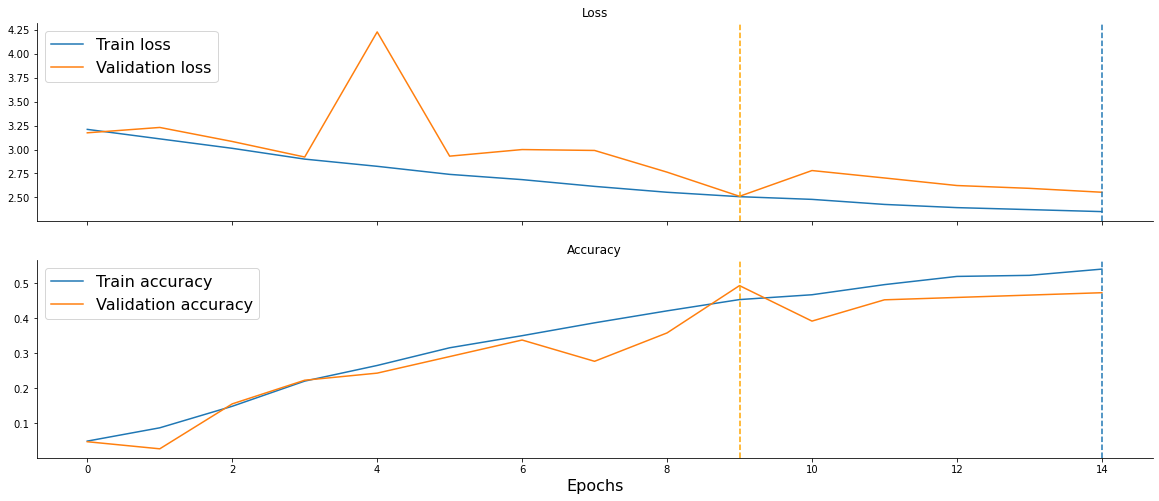


FOLD: 2


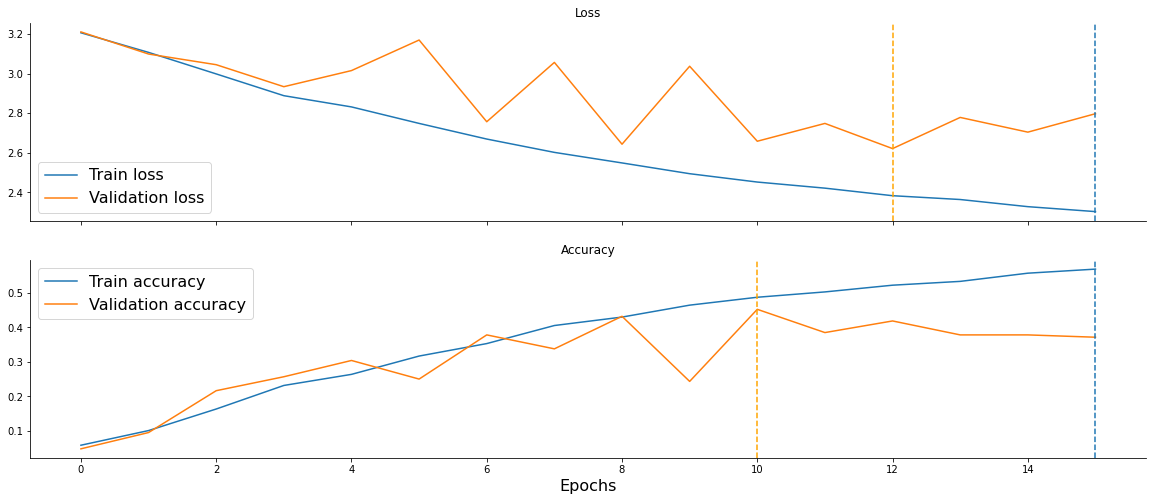


FOLD: 3


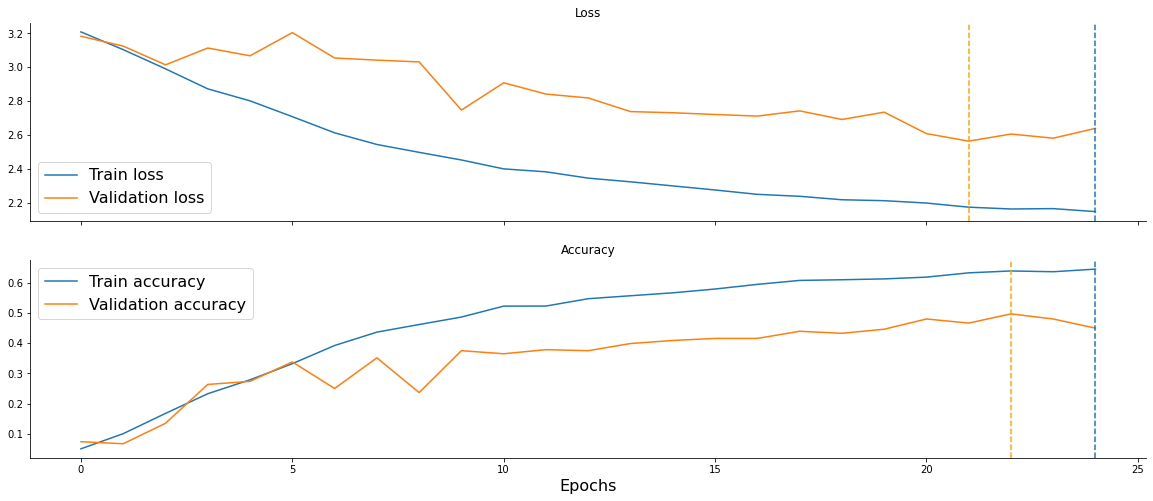


FOLD: 4


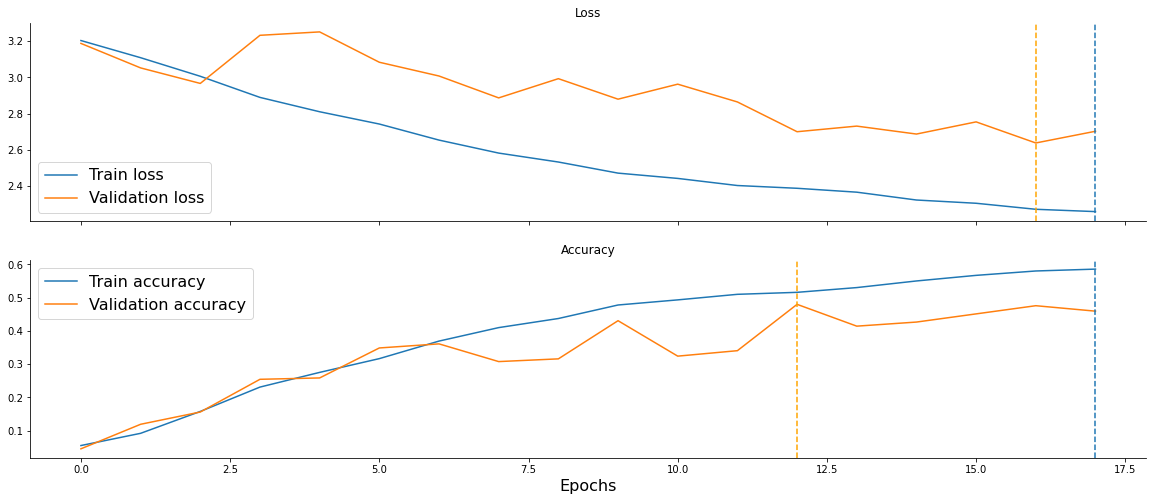


FOLD: 5


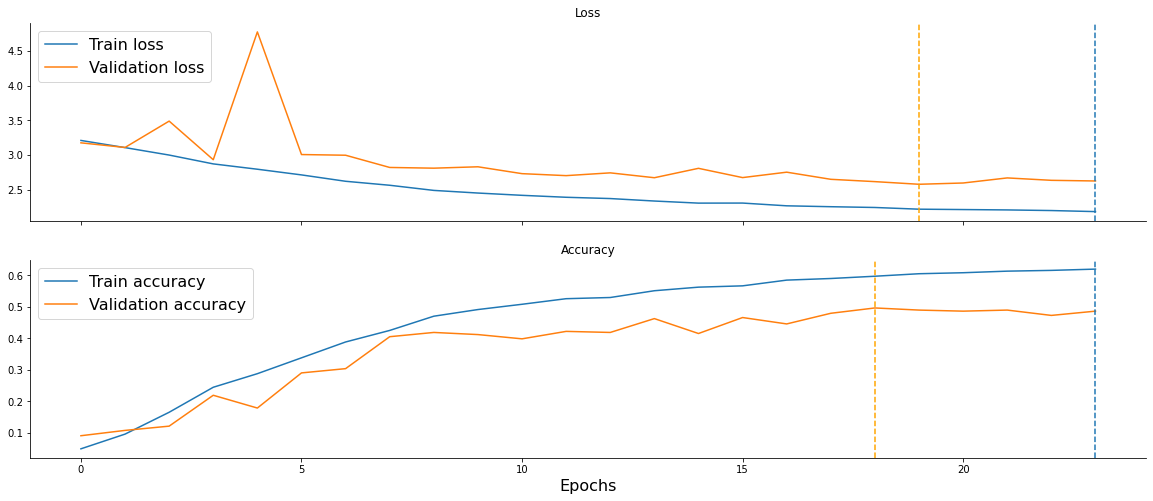

In [12]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

## OOF metrics

In [13]:
print(f"Average OOF accuracy: {np.mean([np.max(history['val_categorical_accuracy']) for history in history_list]):.3f}")
y_true = np.concatenate(oof_labels)
y_pred = np.concatenate(oof_pred)

print(classification_report(y_true, y_pred))

Average OOF accuracy: 0.484
              precision    recall  f1-score   support

           0       0.17      0.14      0.15        50
           1       0.05      0.06      0.06        50
           2       0.21      0.21      0.21        28
           3       0.02      0.02      0.02        48
           4       0.11      0.14      0.12        50
           5       0.11      0.11      0.11        46
           6       0.08      0.06      0.07        49
           7       0.12      0.15      0.13        48
           8       0.07      0.06      0.06        49
           9       0.09      0.10      0.09        31
          10       0.13      0.12      0.12        49
          11       0.09      0.10      0.10        48
          12       0.10      0.10      0.10        49
          13       0.07      0.06      0.06        50
          14       0.17      0.20      0.18        50
          15       0.07      0.05      0.06        43
          16       0.21      0.24      0.23        41

# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

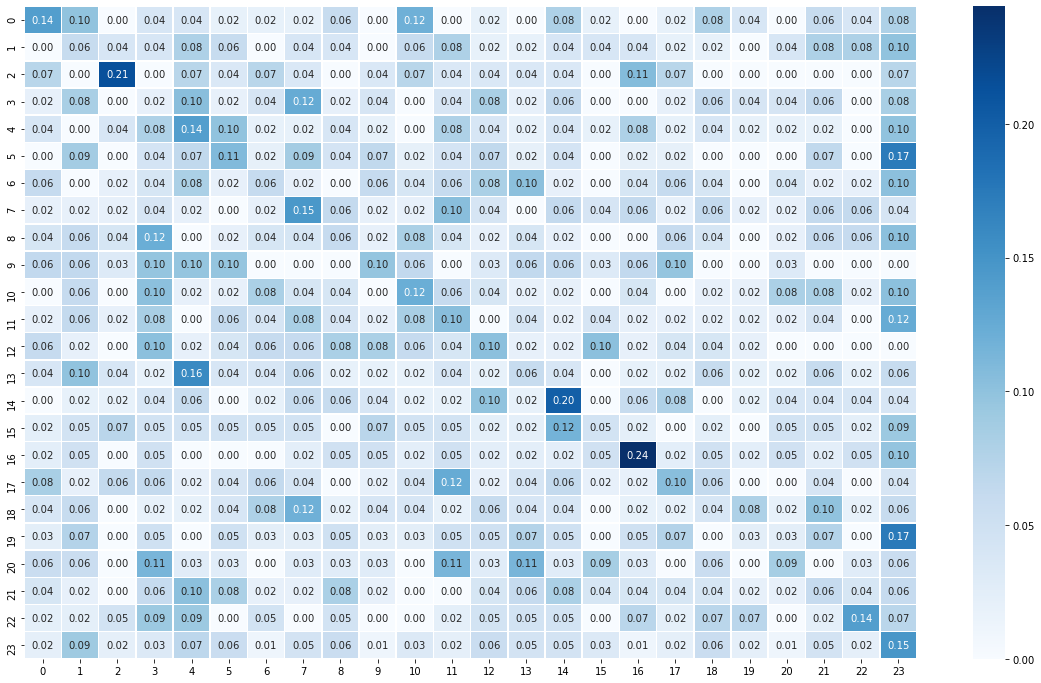

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred)
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, or if it is because the model is actually bad.

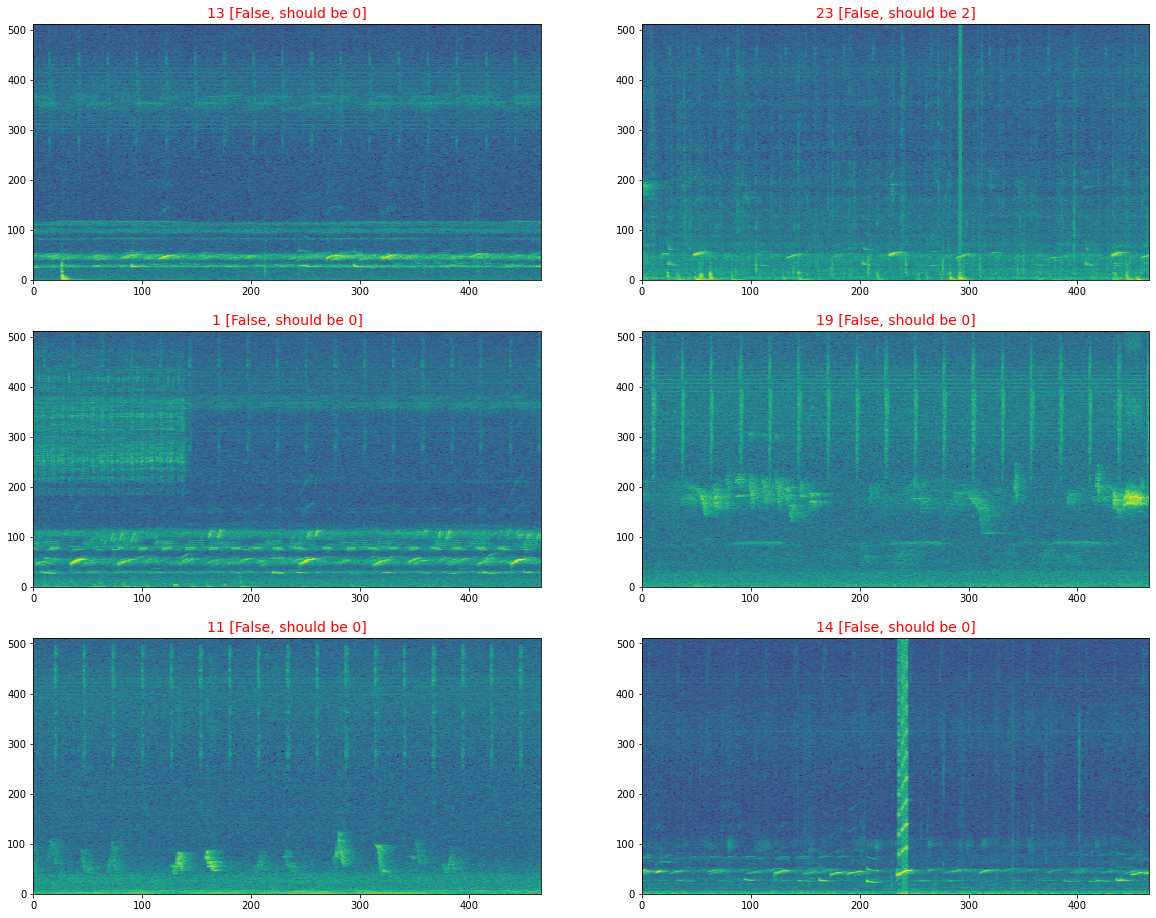

In [15]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)

for features, label in train_dataset.take(1):
    preds = np.argmax(model.predict(features['input_audio']), axis=-1)[:6]
    labels = np.argmax(label.numpy()[:6], axis=-2)
    batch_features = features['input_audio'].numpy()[:6]
    
inspect_preds(batch_features, labels, preds)

# Test set predictions

In [16]:
model_path_list = glob.glob('/kaggle/working/*.h5')
model_path_list.sort()

print('Models to predict:')
print(*model_path_list, sep='\n')

Models to predict:
/kaggle/working/model_0.h5
/kaggle/working/model_1.h5
/kaggle/working/model_2.h5
/kaggle/working/model_3.h5
/kaggle/working/model_4.h5


In [17]:
test_size = count_data_items(TEST_FILENAMES)
test_preds = np.zeros((test_size, N_CLASSES))

for model_path in model_path_list:
    print(model_path)
    K.clear_session()
    model.load_weights(model_path)
    
    test_ds = get_dataset(TEST_FILENAMES, labeled=False, ordered=True, repeated=False).repeat()
    ct_steps = TTA_STEPS * ((test_size/BATCH_SIZE) + 1)
    x_test = test_ds.map(lambda features, recording_id: features['input_audio'])
    preds = model.predict(x_test, steps=ct_steps, verbose=1)[:(test_size * TTA_STEPS)]
    preds = np.mean(preds.reshape(test_size, TTA_STEPS, N_CLASSES, order='F'), axis=1)
    test_preds += preds / len(model_path_list)

names_test_ds = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
names = [features['recording_id'].numpy().decode('utf-8') for features in iter(names_test_ds)]

/kaggle/working/model_0.h5
248/248 [==============================] - 187s 747ms/step
/kaggle/working/model_1.h5
248/248 [==============================] - 180s 724ms/step
/kaggle/working/model_2.h5
248/248 [==============================] - 170s 687ms/step
/kaggle/working/model_3.h5
248/248 [==============================] - 175s 706ms/step
/kaggle/working/model_4.h5
248/248 [==============================] - 173s 699ms/step


In [18]:
submission = pd.DataFrame({'recording_id': names})
for column in range(N_CLASSES):
    submission[f's{column}'] = test_preds[:, column]

submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.032837,0.024562,0.042522,0.065413,0.030904,0.051574,0.020987,0.060806,0.017989,...,0.045595,0.047658,0.053134,0.025871,0.051904,0.062266,0.041616,0.018797,0.038827,0.058601
1,097c4f536,0.020371,0.026582,0.060972,0.080513,0.018886,0.051646,0.025461,0.057176,0.028181,...,0.097867,0.042492,0.055241,0.039011,0.018836,0.029189,0.035934,0.016576,0.034494,0.052468
2,1202a2650,0.019624,0.027070,0.029830,0.058150,0.026408,0.035276,0.027109,0.047960,0.043545,...,0.071060,0.045205,0.036784,0.032863,0.058154,0.032266,0.033752,0.048432,0.022138,0.077415
3,1b171eeb9,0.052333,0.026353,0.061290,0.069506,0.034963,0.031918,0.028117,0.038856,0.025336,...,0.039282,0.054003,0.042702,0.053501,0.032296,0.041673,0.030524,0.021731,0.037509,0.052578
4,226daf7a4,0.026611,0.032634,0.050205,0.076372,0.029480,0.051252,0.020294,0.067556,0.036562,...,0.031244,0.063251,0.048316,0.052027,0.024317,0.033318,0.037300,0.019872,0.037766,0.053165
5,2a855c952,0.046242,0.028064,0.042896,0.097840,0.024566,0.044425,0.024430,0.078817,0.020875,...,0.021965,0.035952,0.053227,0.038708,0.049100,0.032978,0.027827,0.014877,0.036490,0.049235
6,32d052d69,0.025726,0.028065,0.017306,0.098384,0.031017,0.070772,0.044844,0.067811,0.031862,...,0.071245,0.039438,0.060034,0.035024,0.041830,0.024696,0.025122,0.015819,0.027793,0.055983
7,3ba2bdb06,0.035818,0.021628,0.056771,0.086166,0.032226,0.043465,0.032831,0.068795,0.029115,...,0.022710,0.045971,0.042773,0.030188,0.039576,0.028608,0.030174,0.016766,0.030280,0.083739
8,422d116ec,0.051652,0.034056,0.030116,0.080587,0.028393,0.038388,0.024130,0.081472,0.034074,...,0.037949,0.046569,0.051804,0.037731,0.047484,0.026486,0.029026,0.019422,0.027725,0.083192
9,492b3dc52,0.034941,0.026795,0.058183,0.099506,0.023466,0.046227,0.033194,0.080959,0.032549,...,0.027959,0.055746,0.035196,0.039220,0.032222,0.034388,0.026579,0.013923,0.036195,0.056484


# Predicted classes distribution

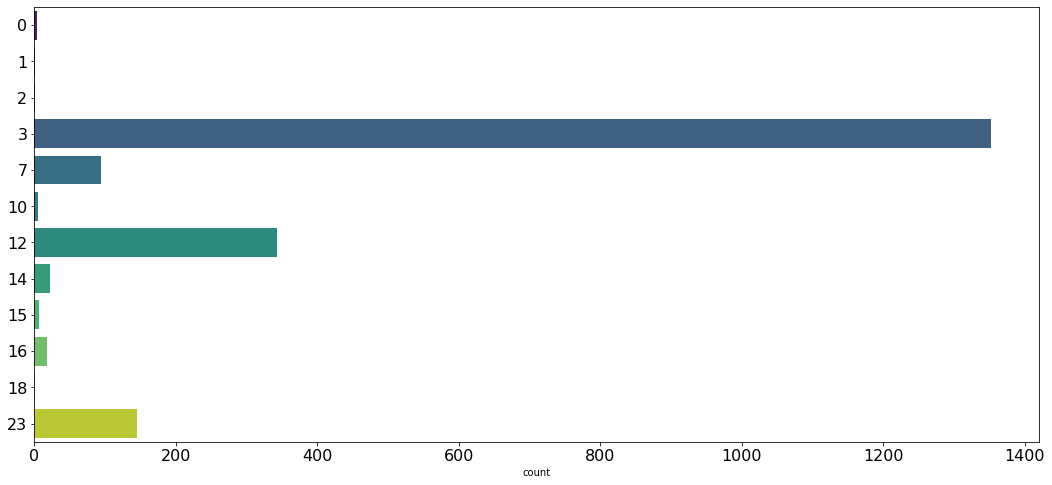

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=test_preds.argmax(axis=-1), palette='viridis')
ax.tick_params(labelsize=16)

plt.show()